In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Waste_Dataset/'
train_path = folder_path + 'TRAIN/'
test_path = folder_path + 'TEST/'

In [ ]:
#Function to structure the data
def folder_data(folder):
  folder_o = os.path.join(folder, 'O')
  folder_r = os.path.join(folder, 'R')
  img_o = os.listdir(folder_o)
  img_r = os.listdir(folder_r)
  org  = [os.path.join(folder_o, i) for i in img_o]
  recy  = [os.path.join(folder_r, i) for i in img_r]
  X = np.array(org + recy, dtype= 'object')
  y = np.array([0]*len(org) + [1]*len(recy))
  return X, y

In [ ]:
X_train, y_train = folder_data(train_path)
X_test, y_test = folder_data(test_path)

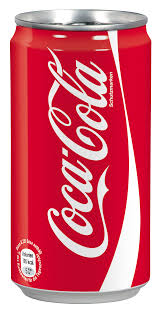

In [ ]:
Image.open(X_train[20000])

In [ ]:
y_train[20000] # 0 for Organic and 1 for Recyclable

1

# **Random Forest**

### Preprocessing of the images

In [ ]:
full_train = np.column_stack((X_train, y_train))
np.random.shuffle(full_train)
train_set = full_train[:, :-1]
y_train_set = full_train[:, -1]

In [ ]:
full_test = np.column_stack((X_test, y_test))
np.random.shuffle(full_test)
test_set = full_test[:, :-1]
y_test_set = full_test[:, -1]

In [ ]:
def resize_img(images_path):
  resized_img = []
  for image in images_path:
    img = cv2.imread(image[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img, (128,128))
    resized_img.append(img_resize)
  return resized_img

In [ ]:
X_train_new = resize_img(train_set[:3000])

In [ ]:
y_train_new = y_train_set[:3000]

In [ ]:
X_test_new = resize_img(test_set)
y_test_new = y_test_set

In [ ]:
X_train_flat_list = [x.ravel() for x in X_train_new]
X_train_new_np = np.vstack(X_train_flat_list)
X_train_new_np.shape

(3000, 49152)

In [ ]:
X_test_flat_list = [x.ravel() for x in X_test_new]
X_test_new_np = np.vstack(X_test_flat_list)
X_test_new_np.shape

(2513, 49152)

In [ ]:
y_train_new = y_train_new.astype(int)
y_test_new = y_test_new.astype(int)

In [ ]:
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test_new_np)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/X_test_scaled.pkl', 'wb') as file:
    pickle.dump(X_test_scaled, file)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train_new_np)

In [ ]:
file_name = ['X_train_scaled.pkl','X_test_scaled.pkl', 'y_train.pkl', 'y_test.pkl' ]
data_file = [X_train_scaled, X_test_scaled, y_train_new, y_test_new]
file_path = '/content/drive/MyDrive/Colab Notebooks/'
for name, data in zip(file_name, data_file):
  with open(file_path+name, 'wb') as file:
    pickle.dump(data, file)

### Random Forest Model

In [ ]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)

# Train the model
rf_classifier.fit(X_train_scaled, y_train_new)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

In [ ]:
with open(file_path +'rf_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/'
with open(file_path+'rf_model.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [ ]:
model1.predict([X_test_scaled[457]])

array([0])

In [ ]:
y_test_new[457]

0

In [ ]:
y_pred = model1.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test_new, y_pred)

In [ ]:
print(f'Accuracy of Random Forest: {accuracy * 100}%')

Accuracy of Random Forest: 85.47552725825707%


In [ ]:
# Calculate precision and recall scores
precision = precision_score(y_test_new, y_pred)
recall = recall_score(y_test_new, y_pred)

# Print the scores
print("Precision:", round(precision*100, 2))
print("Recall:", round(recall*100, 2))

Precision: 90.88
Recall: 75.29


# Transfer Learning

In [ ]:
train_set = np.array(train_set).reshape(-1) #Coverting to 1D
y_train_set = np.array(y_train_set).reshape(-1)
y_train_set = y_train_set.astype(str)
data = pd.DataFrame({'file_path': train_set, 'class_label': y_train_set})

In [ ]:
# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create an instance of the ImageDataGenerator to perform data augmentation and scaling
datagen = ImageDataGenerator(
                               rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode="nearest",
                               validation_split=0.2
                               )

val_gen = ImageDataGenerator(
                             rescale=1./255,
                             validation_split=0.2,
                                    )

train_generator = datagen.flow_from_dataframe(
    data[:3000],
    x_col='file_path',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = val_gen.flow_from_dataframe(
    data[:3000],
    x_col='file_path',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [ ]:
test_set = np.array(test_set).reshape(-1)
y_test_set = np.array(y_test_set).reshape(-1)
y_test_set = y_test_set.astype(str)
test_df = pd.DataFrame({'file_path': test_set, 'class_label': y_test_set})


test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2513 validated image filenames belonging to 2 classes.


In [ ]:
base_model = base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Add your custom classification layers on top of VGG16
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(180, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/model.h5')

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_cb]
)

Epoch 1/30
75/75 [==============================] - 1749s 23s/step - loss: 0.5185 - accuracy: 0.7617 - val_loss: 0.3645 - val_accuracy: 0.8542
Epoch 2/30
75/75 [==============================] - 1695s 23s/step - loss: 0.4064 - accuracy: 0.8300 - val_loss: 0.3217 - val_accuracy: 0.8785
Epoch 3/30
75/75 [==============================] - 1667s 22s/step - loss: 0.3627 - accuracy: 0.8467 - val_loss: 0.3716 - val_accuracy: 0.8438
Epoch 4/30
75/75 [==============================] - 1664s 22s/step - loss: 0.3274 - accuracy: 0.8687 - val_loss: 0.2949 - val_accuracy: 0.8819
Epoch 5/30
75/75 [==============================] - 1685s 22s/step - loss: 0.3172 - accuracy: 0.8704 - val_loss: 0.3112 - val_accuracy: 0.8837
Epoch 6/30
75/75 [==============================] - 1665s 22s/step - loss: 0.3204 - accuracy: 0.8642 - val_loss: 0.2790 - val_accuracy: 0.8837
Epoch 7/30
75/75 [==============================] - 1693s 23s/step - loss: 0.2959 - accuracy: 0.8825 - val_loss: 0.3034 - val_accuracy: 0.8854

In [ ]:
new_train_generator = datagen.flow_from_dataframe(
    data[3000:4000],
    x_col='file_path',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


new_validation_generator = val_gen.flow_from_dataframe(
    data[3000:4000],
    x_col='file_path',
    y_col='class_label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model.h5')
history = model.fit(
    new_train_generator,
    epochs=10,  # Train for additional epochs
    batch_size=32,
    validation_data=new_validation_generator
)
model.save('/content/drive/MyDrive/Colab Notebooks/model_final.h5')

Epoch 1/10
25/25 [==============================] - 681s 27s/step - loss: 0.2650 - accuracy: 0.9000 - val_loss: 0.2183 - val_accuracy: 0.9200
Epoch 2/10
25/25 [==============================] - 648s 26s/step - loss: 0.2560 - accuracy: 0.9000 - val_loss: 0.1760 - val_accuracy: 0.9200
Epoch 3/10
25/25 [==============================] - 648s 26s/step - loss: 0.2363 - accuracy: 0.9287 - val_loss: 0.1818 - val_accuracy: 0.9250
Epoch 4/10
25/25 [==============================] - 651s 26s/step - loss: 0.2408 - accuracy: 0.9075 - val_loss: 0.1798 - val_accuracy: 0.9200
Epoch 5/10
25/25 [==============================] - 648s 26s/step - loss: 0.2464 - accuracy: 0.9013 - val_loss: 0.1804 - val_accuracy: 0.9300
Epoch 6/10
25/25 [==============================] - 650s 26s/step - loss: 0.2153 - accuracy: 0.9250 - val_loss: 0.1966 - val_accuracy: 0.9300
Epoch 7/10
25/25 [==============================] - 649s 26s/step - loss: 0.2084 - accuracy: 0.9162 - val_loss: 0.1822 - val_accuracy: 0.9150
Epoch 

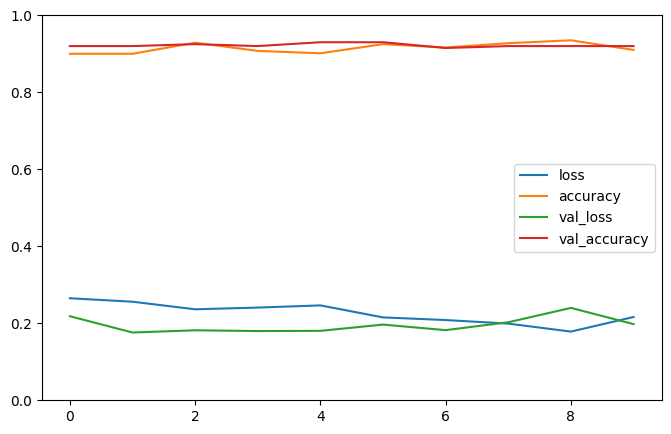

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model_final.h5')
test_loss, test_accuracy = model.evaluate(test_generator)

79/79 [==============================] - 1627s 21s/step - loss: 0.3466 - accuracy: 0.8866


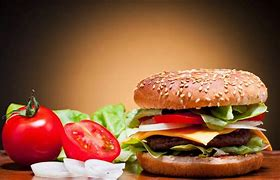

In [ ]:
image_ind = '/content/drive/MyDrive/Colab Notebooks/f_2.jfif'
Image.open(image_ind)

In [ ]:
def sort_waste(image):
  img = cv2.imread(image_ind)
  img = cv2.resize(img, (224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  pred = model.predict(img_array)
  pred = pred.argmax()
  if pred == 1:
    print(f'The waste is Recyclable')
  else:
    print(f'The waste is Organic')
  return

In [ ]:
sort_waste(image_ind)

1/1 [==============================] - 1s 535ms/step
The waste is Organic
